In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import os
import re

In [3]:
os.chdir('/Users/ItelinaMa/Documents/Metis/McNulty/trainingSet')

In [4]:
diagnosisT = pd.read_csv('training_SyncDiagnosis.csv')
allergyT = pd.read_csv('training_SyncAllergy.csv')
immunT = pd.read_csv('training_SyncImmunization.csv')
labObsT = pd.read_csv('training_SyncLabObservation.csv')
labPanT = pd.read_csv('training_SyncLabPanel.csv')
labResT = pd.read_csv('training_SyncLabResult.csv')
medicationT = pd.read_csv('training_SyncMedication.csv')
patientT = pd.read_csv('training_SyncPatient.csv')
patientCondT = pd.read_csv('training_SyncPatientCondition.csv')
smokingT = pd.read_csv('training_SyncPatientSmokingStatus.csv')
prescripT = pd.read_csv('training_SyncPrescription.csv')
trnscrpT = pd.read_csv('training_SyncTranscript.csv')
trnscrpAT = pd.read_csv('training_SyncTranscriptAllergy.csv')
trnscrpDT = pd.read_csv('training_SyncTranscriptDiagnosis.csv')
trnscrptMT = pd.read_csv('training_SyncTranscriptMedication.csv')
myfileT = pd.read_csv('myfile.csv')
conditionT = pd.read_csv('SyncCondition.csv')
smokingT = pd.read_csv('SyncSmokingStatus.csv')

In [5]:
diagnosisT.columns

Index([u'DiagnosisGuid', u'PatientGuid', u'ICD9Code', u'DiagnosisDescription',
       u'StartYear', u'StopYear', u'Acute', u'UserGuid'],
      dtype='object')

#Approach 1

Output file for modeling is patientdata

###Part I: Creating Condition-based Features
Complications/Risk Factors for diabetes
1. CCS Labels Source: https://www.hcup-us.ahrq.gov/toolssoftware/ccs/ccs.jsp
2. Diabetes Type 2 Source: https://en.wikipedia.org/wiki/Diabetes_mellitus_type_2

In [6]:
os.chdir('/Users/ItelinaMa/Documents/Metis/McNulty/Single_Level_CCS_2015')

In [7]:
def cleanString(text):
    result = re.sub("[\'|\"]", "", text)
    return result

In [8]:
CCSN = pd.read_csv('$dxref 2015.csv', skiprows=1)
CCSN.columns = [cleanString(item) for item in CCSN.columns]
for item in CCSN.columns:
    CCSN[item] = CCSN[item].map(cleanString)
    CCSN[item] = CCSN[item].apply(str.strip)
CCSN.columns = ['ICD9', 'CCSN', 'CCS', 'ICD9Descr', 'OptCCS', 'OptCCSDescrp']
CCSN = CCSN.ix[1:, ['ICD9','CCSN']]

In [9]:
CCSLabel = pd.read_csv('dxlabel 2013.csv')
CCSLabel = CCSLabel.ix[3:, :]
CCSLabel.columns = ['CCSN', 'CCSLabel']
CCS = pd.merge(CCSN, CCSLabel, how='inner', on =['CCSN'])

In [10]:
def stripPeriods(text):
    result = re.sub('\.', "", text)
    return result

In [11]:
def ICD9Label(text):
    if bool(re.match('14[0-9]|2[0-3][0-9]', text)) == True:
        return 'neoplasms'
    elif bool(re.match('2[4-7][0-9]', text)) == True:
        return 'endoctrine'
    elif bool(re.match('28[0-9]', text)) == True:
        return 'blood'
    elif bool(re.match('29[0-9]|3[0-1][0-9]', text)) == True:
        return 'mental'
    elif bool(re.match('3[2-5][0-9]', text)) == True:
        return 'nervous'
    elif bool(re.match('3[6-8][0-9]', text)) == True:
        return 'sense'
    elif bool(re.match('39[0-9]|4[0-5][0-9]', text)) == True:
        return 'circulatory'
    elif bool(re.match('4[6-9][0-9]|5[0-1][0-9]', text)) == True:
        return 'respiratory'
    elif bool(re.match('5[2-7][0-9]', text)) == True:
        return 'digestive'
    elif bool(re.match('5[8-9][0-9]|6[0-2][0-9]', text)) == True:
        return 'genitourinary'
    elif bool(re.match('6[3-7][0-9]', text)) == True:
        return 'pregnancy'    
    elif bool(re.match('6[8-9][0-9]|70[0-9]', text)) == True:
        return 'skin'   
    elif bool(re.match('7[1-3][0-9]', text)) == True:
        return 'musculoskeletal'       
    elif bool(re.match('7[4-5][0-9]', text)) == True:
        return 'congenital' 
    elif bool(re.match('7[6-7][0-9]', text)) == True:
        return 'perinatal' 
    elif bool(re.match('7[8-9][0-9]', text)) == True:
        return 'symptoms or ill-defined' 
    elif bool(re.match('8[0-9][0-9]|9[0-9][0-9]', text)) == True:
        return 'injuries' 
    elif bool(re.match('E|V', text)) == True:
        return 'suppl' 
    else:
        return 'infectious'

In [12]:
def heartDisease(text):
    if bool(re.match('41[0-4]|42[0-5]|427|429|74[5-6]', text)) == True:
        return 1
    return 0
def CAD(text):
    if bool(re.match('41[0-4]|429', text)) == True:
        return 1
    return 0
def cardiomyopathy(text):
    if bool(re.match('42[0-5]', text)) == True:
        return 1
    return 0
def CHF(text):
    if bool(re.match('426', text)) == True:
        return 1
    return 0
def arrhythmias(text):
    if bool(re.match('427', text)) == True:
        return 1
    return 0
def heartdefects(text):
    if bool(re.match('74[5-6]', text)) == True:
        return 1
    return 0
def stroke(text):
    if bool(re.match('43[0-1]|43[3-6]|997.02', text)) == True:
        return 1
    return 0
def sleepApnea(text):
    if bool(re.match('727.23|780.57', text)) == True:
        return 1
    return 0
def gestDiab(text):
    if bool(re.match('648.8', text)) == True:
        return 1
    return 0
def polyOvary(text):
    if bool(re.match('256.4', text)) == True:
        return 1
    return 0
def frozenShoulder(text):
    if bool(re.match('726.0', text)) == True:
        return 1
    return 0
def hemochr(text):
    if bool(re.match('275.03', text)) == True:
        return 1
    return 0
def hepatitis(text):
    if bool(re.match('070.2|070.3', text)) == True:
        return 1
    return 0
def diabCompl(text):
    if bool(re.match('250.[1-3]|250.5|250.8|251.[0-2]|270.3|775.6|962.3', text)) == True:
        return 1
    return 0
def kidneyFailure(text):
    if bool(re.match('58[4-5]', text)) == True:
        return 1
    return 0
def dementia(text):
    if bool(re.match('331|290|294|797', text)) == True:
        return 1
    return 0
def acanthosis(text):
    if bool(re.match('701.2', text)) == True:
        return 1
    return 0
def blindness(text):
    if bool(re.match('369', text)) == True:
        return 1
    return 0
def sDysfunction(text):
    if bool(re.match('302.7', text)) == True:
        return 1
    return 0
def preDiabetes(text):
    if bool(re.match('790.29', text)) == True:
        return 1
    return 0

In [13]:
diagnosisT['ICD9'] = diagnosisT['ICD9Code'].apply(stripPeriods)
diagnosisT['hasHeartDisease'] = diagnosisT['ICD9Code'].apply(heartDisease)
diagnosisT['hasCAD'] = diagnosisT['ICD9Code'].apply(CAD)
diagnosisT['hasCardiomyo'] = diagnosisT['ICD9Code'].apply(cardiomyopathy)
diagnosisT['hasArrhy'] = diagnosisT['ICD9Code'].apply(arrhythmias)
diagnosisT['hasHeartDefects'] = diagnosisT['ICD9Code'].apply(heartdefects)
diagnosisT['hasCHF'] = diagnosisT['ICD9Code'].apply(CHF)
diagnosisT['hasStroke'] = diagnosisT['ICD9Code'].apply(stroke)
diagnosisT['hasSleepA'] = diagnosisT['ICD9Code'].apply(sleepApnea)
diagnosisT['hasGestDiab'] = diagnosisT['ICD9Code'].apply(gestDiab)
diagnosisT['hasPolyO'] = diagnosisT['ICD9Code'].apply(polyOvary)
diagnosisT['hasFrozenShoulder'] = diagnosisT['ICD9Code'].apply(frozenShoulder)
diagnosisT['hasHemoChr'] = diagnosisT['ICD9Code'].apply(hemochr)
diagnosisT['hasHepatitis'] = diagnosisT['ICD9Code'].apply(hepatitis)
diagnosisT['hasDiabComp'] = diagnosisT['ICD9Code'].apply(diabCompl)
diagnosisT['hasKidneyF'] = diagnosisT['ICD9Code'].apply(kidneyFailure)
diagnosisT['hasDementia'] = diagnosisT['ICD9Code'].apply(dementia)
diagnosisT['hasAcanthosis'] = diagnosisT['ICD9Code'].apply(acanthosis)
diagnosisT['hasBlindness'] = diagnosisT['ICD9Code'].apply(blindness)
diagnosisT['hasSDysf'] = diagnosisT['ICD9Code'].apply(sDysfunction)
diagnosisT['hasPreDiab'] = diagnosisT['ICD9Code'].apply(preDiabetes)

In [14]:
dataset1 = pd.merge(diagnosisT, CCS, how='inner', on =['ICD9'])
dataset1['ICD9Label'] = dataset1['ICD9Code'].apply(ICD9Label)

In [15]:
ICD9Labels = dataset1.ix[:, ['PatientGuid', 'ICD9Label']].drop_duplicates()
ICD9Labels['counts'] = 1
ICD9Labels = ICD9Labels.pivot('PatientGuid', 'ICD9Label', 'counts')
ICD9Labels = ICD9Labels.fillna(0).reset_index()

In [16]:
diagnosisSummary = dataset1.groupby(['PatientGuid'])[['hasHeartDisease', 'hasCHF', 'hasStroke', 'hasSleepA', 'hasGestDiab','hasPolyO', 'hasFrozenShoulder', 'hasHemoChr','hasHepatitis', 'hasDiabComp', 'hasKidneyF', 'hasDementia','hasAcanthosis', 'hasBlindness' ,'hasSDysf', 'hasPreDiab']].max()
diagnosisSummary = diagnosisSummary.reset_index()
columns = diagnosisSummary.columns[1:]
diagnosisSummary['SumRiskFactor'] = diagnosisSummary[columns].sum(axis=1)
diagnosisSummary['NoRiskFactor'] = 1
diagnosisSummary.loc[diagnosisSummary['SumRiskFactor'] > 0, 'NoRiskFactor'] = 0
diagnosisSummary = diagnosisSummary.drop('SumRiskFactor', 1)

In [17]:
patientdata = pd.merge(patientT, diagnosisSummary, how='inner', on =['PatientGuid'])
patientdata = pd.merge(patientdata, ICD9Labels, how='inner', on =['PatientGuid'])

In [18]:
complfactors = patientdata.columns[6:27]
ICD9levels = patientdata.columns[27:]

In [19]:
diagsummary = patientdata.groupby(['DMIndicator'])[complfactors].sum().T
diagsummary.columns =["No", 'Yes']
diagsummary['Percentage'] = diagsummary['Yes']/(diagsummary["No"] + diagsummary["Yes"])
diagsummary.sort('Percentage', ascending=False)

,No,Yes,Percentage
hasKidneyF,160,195,0.549296
hasDiabComp,37,26,0.412698
hasBlindness,16,9,0.360000
hasSDysf,54,29,0.349398
hasStroke,117,61,0.342697
hasSleepA,43,22,0.338462
hasPreDiab,155,76,0.329004
hasHeartDisease,792,374,0.320755
hasHepatitis,13,6,0.315789
blood,598,271,0.311853


###Part II: Creating Features based on Transcripts
Weight/BMI, Blood Pressure
1. BMI Source: http://www.who.int/mediacentre/factsheets/fs311/en/
2. Blood Pressure Source: http://www.nhlbi.nih.gov/health/health-topics/topics/hbp

In [20]:
trnscrpT.head(5)
trnscrpT['BMI'] = trnscrpT['BMI'].replace(0.000, np.nan)

In [21]:
bmi1 = trnscrpT.groupby(['PatientGuid'])['BMI'].mean()
bmi2 = trnscrpT.groupby(['PatientGuid'])['BMI'].max()
bmi3 = trnscrpT.groupby(['PatientGuid'])['BMI'].min()
bmi = pd.concat([bmi1, bmi2, bmi3], axis = 1)
bmi.columns = ['MeanBMI', 'MaxBMI', 'MinBMI']
bmi['isOverweight'] = 0
bmi['isObese'] = 0
bmi.loc[(bmi['MeanBMI'] >= 25) & (bmi['MeanBMI'] < 30), 'isOverweight'] = 1
bmi.loc[bmi['MeanBMI'] >= 30, 'isObese'] = 1
bmi['BMIDiff'] = np.abs(bmi['MaxBMI'] - bmi['MinBMI'])
bmi['NotOverweight'] = 1
bmi.loc[(bmi['isOverweight'] == 1) | (bmi['isObese'] == 1), 'NotOverweight'] = 0 
bmi = bmi.reset_index()

In [22]:
patientdata = pd.merge(patientdata, bmi, how='inner', on =['PatientGuid'])
patientdata.shape

(9915, 49)

In [23]:
bloodpressure1 = trnscrpT.groupby(['PatientGuid'])[['SystolicBP', 'DiastolicBP']].mean()
bloodpressure2 = trnscrpT.groupby(['PatientGuid'])[['SystolicBP', 'DiastolicBP']].max()
bloodpressure3 = trnscrpT.groupby(['PatientGuid'])[['SystolicBP', 'DiastolicBP']].min()
bloodpressure = pd.concat([bloodpressure1, bloodpressure2, bloodpressure3], axis = 1)
bloodpressure.columns = ['meanSystolicBP', 'meanDiastolicBP', 'maxSystolicBP', 'maxDiastolicBP', 'minSystolicBP', 'minDiastolicBP']
bloodpressure['SystDiff'] = np.abs(bloodpressure['maxSystolicBP'] - bloodpressure['minSystolicBP'])
bloodpressure['DiastDiff'] = np.abs(bloodpressure['maxDiastolicBP'] - bloodpressure['minDiastolicBP'])
bloodpressure['isPreHyp'] = 0
bloodpressure['isStage1HBP'] = 0
bloodpressure['isStage2HBP'] = 0
bloodpressure.loc[((bloodpressure['meanSystolicBP'] >= 120) & (bloodpressure['meanSystolicBP'] < 140)) | ((bloodpressure['meanDiastolicBP'] >= 80) & (bloodpressure['meanDiastolicBP'] < 90)), 'isPreHyp'] = 1
bloodpressure.loc[((bloodpressure['meanSystolicBP'] >= 140) & (bloodpressure['meanSystolicBP'] < 160)) | ((bloodpressure['meanDiastolicBP'] >= 90) & (bloodpressure['meanDiastolicBP'] < 100)), 'isStage1HBP'] = 1
bloodpressure.loc[(bloodpressure['meanSystolicBP'] >= 160) | (bloodpressure['meanDiastolicBP'] >= 100), 'isStage2HBP'] = 1
bloodpressure.loc[bloodpressure['isStage2HBP'] == 1, 'isStage1HBP'] = 0
bloodpressure.loc[bloodpressure['isStage1HBP'] == 1, 'isPreHyp'] = 0
bloodpressure = bloodpressure.reset_index()

In [24]:
patientdata = pd.merge(patientdata, bloodpressure, how='inner', on =['PatientGuid'])
patientdata.shape

(9915, 60)

In [25]:
patientdata['Age'] = 2015 - patientdata['YearOfBirth']

In [26]:
patientdata.groupby(['DMIndicator'])['BMIDiff', 'SystDiff', 'DiastDiff'].mean().T

DMIndicator,0,1
BMIDiff,117.663003,43.137776
SystDiff,27.054550,36.220179
DiastDiff,18.722756,22.703100


In [27]:
bodyweight = patientdata.groupby(['DMIndicator'])['isOverweight','isObese', 'NotOverweight'].sum().T
bodyweight.columns =["No", 'Yes']
bodyweight['Percentage'] = bodyweight['Yes']/(bodyweight["No"] + bodyweight["Yes"])
bodyweight.sort('Percentage', ascending=False)

,No,Yes,Percentage
isObese,2841,1054,0.270603
isOverweight,2686,586,0.179095
NotOverweight,2485,263,0.095706


In [28]:
bloodprs = patientdata.groupby(['DMIndicator'])['isPreHyp','isStage1HBP', 'isStage2HBP'].sum().T
bloodprs.columns =["No", 'Yes']
bloodprs['Percentage'] = bloodprs['Yes']/(bloodprs["No"] + bloodprs["Yes"])
bloodprs.sort('Percentage', ascending=False)

,No,Yes,Percentage
isStage2HBP,128,67,0.343590
isStage1HBP,1008,397,0.282562
isPreHyp,4277,1128,0.208696


In [29]:
patientdata.DMIndicator.value_counts()

0    8012
1    1903
dtype: int64

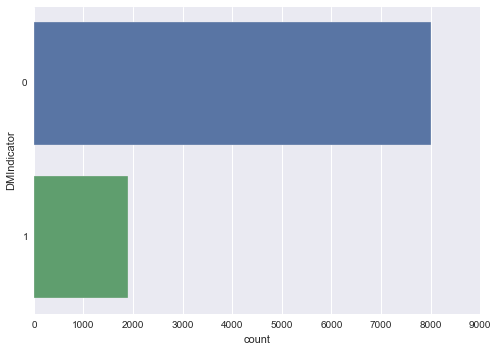

In [30]:
%matplotlib inline
matplotlib.style.use('ggplot')
import seaborn as sns
ax = sns.countplot(y="DMIndicator", data=patientdata)
ax

#Approach 2

Output file for modeling is patientdata2

In [31]:
os.chdir('/Users/ItelinaMa/Documents/Metis/McNulty/trainingSet')
diagnosisT = pd.read_csv('training_SyncDiagnosis.csv')
allergyT = pd.read_csv('training_SyncAllergy.csv')
immunT = pd.read_csv('training_SyncImmunization.csv')
labObsT = pd.read_csv('training_SyncLabObservation.csv')
labPanT = pd.read_csv('training_SyncLabPanel.csv')
labResT = pd.read_csv('training_SyncLabResult.csv')
medicationT = pd.read_csv('training_SyncMedication.csv')
patientT = pd.read_csv('training_SyncPatient.csv')
patientCondT = pd.read_csv('training_SyncPatientCondition.csv')
smokingT = pd.read_csv('training_SyncPatientSmokingStatus.csv')
prescripT = pd.read_csv('training_SyncPrescription.csv')
trnscrpT = pd.read_csv('training_SyncTranscript.csv')
trnscrpAT = pd.read_csv('training_SyncTranscriptAllergy.csv')
trnscrpDT = pd.read_csv('training_SyncTranscriptDiagnosis.csv')
trnscrptMT = pd.read_csv('training_SyncTranscriptMedication.csv')
myfileT = pd.read_csv('myfile.csv')
conditionT = pd.read_csv('SyncCondition.csv')
smokingT = pd.read_csv('SyncSmokingStatus.csv')

#####Detailed Analysis of Conditions had by Diabetic Patients

In [32]:
import numpy as np
import pandas as pd
from random import sample

In [33]:
def getDiabeticCodes(dinput):
    diaganalysis=dinput
    diaganalysis = diaganalysis.groupby(['DMIndicator', 'ICD9Code'])['PatientGuid'].value_counts().reset_index()
    diaganalysis.columns = ['DMIndicator','ICD9Code','level_2', 'Counts']
    diaganalysis.loc[diaganalysis['Counts'] > 1, 'Counts'] = 1
    diaganalysis = diaganalysis.groupby(['ICD9Code','DMIndicator', ])['Counts'].sum().reset_index()
    diaganalysis = diaganalysis.pivot('ICD9Code', 'DMIndicator', 'Counts')
    diaganalysis = diaganalysis.fillna(0)
    diaganalysis.columns = ['No', 'Yes']
    diaganalysis = diaganalysis.reset_index()
    diaganalysis['Percentage'] = diaganalysis['Yes']/(diaganalysis['No'] + diaganalysis['Yes'])
    diaganalysis['total'] = diaganalysis['No'] + diaganalysis['Yes']
    summarydata = diaganalysis[(diaganalysis['total'] >= 5) & (diaganalysis['Percentage'] >= 0.20)][['ICD9Code', 'No', 'Yes', 'Percentage', 'total']]
    ICD9list = summarydata['ICD9Code'].unique()
    return ICD9list

In [34]:
diaganalysis = pd.merge(patientT, diagnosisT, on=['PatientGuid'])

In [35]:
diagnosisT['ICD9Label'] = diagnosisT['ICD9Code'].apply(ICD9Label)
diagnosisT['Counts'] = 1
ICD9Labeldata = diagnosisT.groupby(['PatientGuid', 'ICD9Label'])['Counts'].sum().reset_index().pivot('PatientGuid', 'ICD9Label', 'Counts').reset_index()
ICD9Labeldata = ICD9Labeldata.fillna(0)

In [36]:
print ICD9Labeldata.columns

Index([u'PatientGuid', u'blood', u'circulatory', u'congenital', u'digestive',
       u'endoctrine', u'genitourinary', u'infectious', u'injuries', u'mental',
       u'musculoskeletal', u'neoplasms', u'nervous', u'perinatal',
       u'pregnancy', u'respiratory', u'sense', u'skin', u'suppl',
       u'symptoms or ill-defined'],
      dtype='object', name=u'ICD9Label')


In [37]:
rindexlist = []
i = 0
while i < 25:
    rindex = np.array(sample(xrange(len(diaganalysis)), 63000))
    rindexlist.append(rindex)
    i += 1
datasets = []
for item in rindexlist:
    dataset = diaganalysis.ix[item]
    datasets.append(dataset)
ICD9list = []
for item in datasets:
    ICD9 = set(getDiabeticCodes(item))
    ICD9list.append(ICD9)
commonICD9 = ICD9list[0]
for i in range(1, len(ICD9list)):
    commonICD9 = commonICD9.intersection(ICD9list[i])
diaganalysis['RiskFactors'] = diaganalysis[diaganalysis['ICD9Code'].isin(commonICD9)]['ICD9Code']
riskfactors = pd.get_dummies(diaganalysis['RiskFactors'])
riskfactors = riskfactors.fillna(0)
diaganalysis = diaganalysis['PatientGuid']
diaganalysis = pd.concat([diaganalysis, riskfactors, ], axis=1)

In [38]:
print len(commonICD9), diaganalysis.shape[1]

233 234


In [39]:
print diaganalysis.columns

Index([u'PatientGuid', u'008.69', u'009.0', u'009.3', u'053.8', u'053.9',
       u'070.54', u'110.4', u'110.5', u'110.8', 
       ...
       u'V15.81', u'V15.88', u'V45.81', u'V45.82', u'V58.61', u'V65.42',
       u'V69.1', u'V72.81', u'V76.51', u'V79.0'],
      dtype='object', length=234)


In [40]:
diagsummary = diaganalysis.groupby(['PatientGuid']).sum().reset_index()

In [41]:
patientdata2 = pd.merge(patientT, ICD9Labeldata, how='inner', on =['PatientGuid'])
patientdata2 = pd.merge(patientdata2, diagnosisSummary, how='inner', on =['PatientGuid'])
patientdata2 = pd.merge(patientdata2, diagsummary, how='inner', on =['PatientGuid'])
patientdata2 = pd.merge(patientdata2, bloodpressure, how='inner', on =['PatientGuid'])
patientdata2 = pd.merge(patientdata2, bmi, how='inner', on =['PatientGuid'])
patientdata2['Age'] = 2015 - patientdata2['YearOfBirth']

##Approach 3: Use Cosine Similarity to automatically detect top diseases

output is patientdata3

In [42]:
os.chdir('/Users/ItelinaMa/Documents/Metis/McNulty/trainingSet')
diagnosisT = pd.read_csv('training_SyncDiagnosis.csv')
allergyT = pd.read_csv('training_SyncAllergy.csv')
immunT = pd.read_csv('training_SyncImmunization.csv')
labObsT = pd.read_csv('training_SyncLabObservation.csv')
labPanT = pd.read_csv('training_SyncLabPanel.csv')
labResT = pd.read_csv('training_SyncLabResult.csv')
medicationT = pd.read_csv('training_SyncMedication.csv')
patientT = pd.read_csv('training_SyncPatient.csv')
patientCondT = pd.read_csv('training_SyncPatientCondition.csv')
smokingT = pd.read_csv('training_SyncPatientSmokingStatus.csv')
prescripT = pd.read_csv('training_SyncPrescription.csv')
trnscrpT = pd.read_csv('training_SyncTranscript.csv')
trnscrpAT = pd.read_csv('training_SyncTranscriptAllergy.csv')
trnscrpDT = pd.read_csv('training_SyncTranscriptDiagnosis.csv')
trnscrptMT = pd.read_csv('training_SyncTranscriptMedication.csv')
myfileT = pd.read_csv('myfile.csv')
conditionT = pd.read_csv('SyncCondition.csv')
smokingT = pd.read_csv('SyncSmokingStatus.csv')

In [43]:
diaganalysis = pd.merge(patientT, diagnosisT, on=['PatientGuid'])

In [44]:
chidata = diaganalysis[['PatientGuid', 'DMIndicator', 'ICD9Code']].drop_duplicates()
chidata.index = chidata['PatientGuid']
dummies = pd.get_dummies(chidata['ICD9Code']).reset_index()
dummies = dummies.groupby(['PatientGuid'])[dummies.columns[1:]].sum()
dummies = dummies.replace(2, 1)
chidata = chidata[['PatientGuid', 'DMIndicator']]
chidata = chidata.drop_duplicates()

In [45]:
print chidata.shape, dummies.shape

(9948, 2) (9948, 3943)


In [46]:
chidata = pd.concat([chidata, dummies], axis=1)
chidata['DMIndicator'] = chidata['DMIndicator'].astype(float)

In [47]:
import numpy
import scipy.stats as scs
from collections import defaultdict
from scipy import spatial
from sklearn.metrics import *
columns = chidata.columns[2:]
chitest = {}
cmatrix = {}
cos = {}
percent = {}
for column in columns:
    cm = confusion_matrix(np.array(chidata['DMIndicator']), np.array(chidata[column]))
    cmatrix[column] = cm
    chitest[column]= scs.chi2_contingency(cm)[1]
    cos[column] = 1 - spatial.distance.cosine(chidata['DMIndicator'], chidata[column])
    percent[column] = float(cm[1][1])/(float(cm[0][1]) + float(cm[1][1]))

In [48]:
print cmatrix['250.61'], percent['250.61'], cos['250.61']

[[8042    2]
 [1857   47]] 0.959183673469 0.153874390573


In [49]:
df1 = pd.DataFrame(chitest.items(), columns = ['ICD9', 'PvalueChi'])
df1.index=df1['ICD9']
df2 = pd.DataFrame(cos.items(), columns = ['ICD9', 'CosSimilarity'])
df2.index=df2['ICD9']
df3 = pd.DataFrame(percent.items(), columns = ['ICD9', 'PercentDiabetics'])
df3.index=df3['ICD9']
df = pd.merge(df1, df2, on='ICD9')
df = pd.merge(df, df3, on='ICD9')
df = df.sort('CosSimilarity', ascending=False)

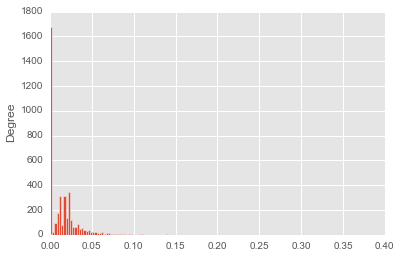

In [50]:
%matplotlib inline
matplotlib.style.use('ggplot')
df['CosSimilarity'].plot(kind='hist', bins=150)

In [51]:
diaganalysis = pd.merge(patientT, diagnosisT, on=['PatientGuid'])
similarICD9 = df[df['CosSimilarity'] > 0.05]['ICD9']
diaganalysis['RiskFactors'] = diaganalysis[diaganalysis['ICD9Code'].isin(similarICD9)]['ICD9Code']
riskfactors = pd.get_dummies(diaganalysis['RiskFactors'])
riskfactors = riskfactors.fillna(0)
diaganalysis = diaganalysis['PatientGuid']
diaganalysis = pd.concat([diaganalysis, riskfactors], axis=1)
diagsummary = diaganalysis.groupby(['PatientGuid']).sum().reset_index()
patientdata3 = pd.merge(patientT, ICD9Labeldata, how='inner', on =['PatientGuid'])
patientdata3 = pd.merge(patientdata3, diagnosisSummary, how='inner', on =['PatientGuid'])
patientdata3 = pd.merge(patientdata3, diagsummary, how='inner', on =['PatientGuid'])
patientdata3 = pd.merge(patientdata3, bloodpressure, how='inner', on =['PatientGuid'])
patientdata3 = pd.merge(patientdata3, bmi, how='inner', on =['PatientGuid'])
patientdata3['Age'] = 2015 - patientdata3['YearOfBirth']

In [52]:
len(similarICD9)

231

###Modeling

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from patsy import dmatrices

####Model set 1

In [54]:
patientdata.columns

Index([u'PatientGuid', u'DMIndicator', u'Gender', u'YearOfBirth', u'State',
       u'PracticeGuid', u'hasHeartDisease', u'hasCHF', u'hasStroke',
       u'hasSleepA', u'hasGestDiab', u'hasPolyO', u'hasFrozenShoulder',
       u'hasHemoChr', u'hasHepatitis', u'hasDiabComp', u'hasKidneyF',
       u'hasDementia', u'hasAcanthosis', u'hasBlindness', u'hasSDysf',
       u'hasPreDiab', u'NoRiskFactor', u'blood', u'circulatory', u'congenital',
       u'digestive', u'endoctrine', u'genitourinary', u'infectious',
       u'injuries', u'mental', u'musculoskeletal', u'neoplasms', u'nervous',
       u'perinatal', u'pregnancy', u'respiratory', u'sense', u'skin', u'suppl',
       u'symptoms or ill-defined', u'MeanBMI', u'MaxBMI', u'MinBMI',
       u'isOverweight', u'isObese', u'BMIDiff', u'NotOverweight',
       u'meanSystolicBP', u'meanDiastolicBP', u'maxSystolicBP',
       u'maxDiastolicBP', u'minSystolicBP', u'minDiastolicBP', u'SystDiff',
       u'DiastDiff', u'isPreHyp', u'isStage1HBP', u'isStage2H

In [55]:
modelelements = patientdata.columns[6:64]
modelelements = '") + Q("'.join(modelelements)
formula = 'DMIndicator ~ Q("Gender") + Q("Age") + Q(' + modelelements + '")'
formula

'DMIndicator ~ Q("Gender") + Q("Age") + Q(hasHeartDisease") + Q("hasCHF") + Q("hasStroke") + Q("hasSleepA") + Q("hasGestDiab") + Q("hasPolyO") + Q("hasFrozenShoulder") + Q("hasHemoChr") + Q("hasHepatitis") + Q("hasDiabComp") + Q("hasKidneyF") + Q("hasDementia") + Q("hasAcanthosis") + Q("hasBlindness") + Q("hasSDysf") + Q("hasPreDiab") + Q("NoRiskFactor") + Q("blood") + Q("circulatory") + Q("congenital") + Q("digestive") + Q("endoctrine") + Q("genitourinary") + Q("infectious") + Q("injuries") + Q("mental") + Q("musculoskeletal") + Q("neoplasms") + Q("nervous") + Q("perinatal") + Q("pregnancy") + Q("respiratory") + Q("sense") + Q("skin") + Q("suppl") + Q("symptoms or ill-defined") + Q("MeanBMI") + Q("MaxBMI") + Q("MinBMI") + Q("isOverweight") + Q("isObese") + Q("BMIDiff") + Q("NotOverweight") + Q("meanSystolicBP") + Q("meanDiastolicBP") + Q("maxSystolicBP") + Q("maxDiastolicBP") + Q("minSystolicBP") + Q("minDiastolicBP") + Q("SystDiff") + Q("DiastDiff") + Q("isPreHyp") + Q("isStage1HBP")

In [56]:
#y, X = dmatrices('DMIndicator ~ Q("Gender") + Q("Age") + Q("hasHeartDisease") + Q("hasCAD") + Q("hasCardiomyo") + Q("hasArrhy") + Q("hasHeartDefects") + Q("hasStroke") + Q("hasSleepA") + Q("hasGestDiab") + Q("hasPolyO") + Q("hasFrozenShoulder") + Q("hasHemoChr") + Q("hasHepatitis") + Q("hasDiabComp") + Q("hasKidneyF") + Q("hasDementia") + Q("hasAcanthosis") + Q("hasBlindness") + Q("hasSDysf") + Q("hasPreDiab") + Q("blood") + Q("circulatory") + Q("congenital") + Q("digestive") + Q("endoctrine") + Q("genitourinary") + Q("infectious") + Q("injuries") + Q("mental") + Q("musculoskeletal") + Q("neoplasms") + Q("nervous") + Q("perinatal") + Q("pregnancy") + Q("respiratory") + Q("sense") + Q("skin") + Q("suppl") + Q("symptoms or ill-defined") + Q("MeanBMI") + Q("MaxBMI") + Q("MinBMI") + Q("isOverweight") + Q("isObese") + Q("BMIDiff") + Q("meanSystolicBP") + Q("meanDiastolicBP") + Q("maxSystolicBP") + Q("maxDiastolicBP") + Q("minSystolicBP") + Q("minDiastolicBP") + Q("SystDiff") + Q("DiastDiff") + Q("isPreHyp") + Q("isStage1HBP") + Q("isStage2HBP")', data=patientdata, return_type='dataframe')

In [57]:
#y, X = dmatrices('DMIndicator ~ Q("Gender") + Q("Age") + Q("hasHeartDisease") +  Q("hasCHF") + Q("hasStroke") + Q("hasSleepA") + Q("hasGestDiab") + Q("hasPolyO") + Q("hasFrozenShoulder") + Q("hasHemoChr") + Q("hasHepatitis") + Q("hasDiabComp") + Q("hasKidneyF") + Q("hasDementia") + Q("hasAcanthosis") + Q("hasBlindness") + Q("hasSDysf") + Q("hasPreDiab") + Q("MeanBMI") + Q("isOverweight") + Q("isObese") + Q("meanSystolicBP") + Q("meanDiastolicBP") + Q("isPreHyp") + Q("isStage1HBP") + Q("isStage2HBP")', data=patientdata, return_type='dataframe')

In [58]:
#y, X = dmatrices(formula, data=patientdata, return_type='dataframe')

####Model Set 2

In [59]:
patientdata2.columns[42:(42+len(commonICD9))]

Index([u'008.69', u'009.0', u'009.3', u'053.8', u'053.9', u'070.54', u'110.4',
       u'110.5', u'110.8', u'112.2', 
       ...
       u'V15.81', u'V15.88', u'V45.81', u'V45.82', u'V58.61', u'V65.42',
       u'V69.1', u'V72.81', u'V76.51', u'V79.0'],
      dtype='object', length=233)

In [60]:
patientdata.columns

Index([u'PatientGuid', u'DMIndicator', u'Gender', u'YearOfBirth', u'State',
       u'PracticeGuid', u'hasHeartDisease', u'hasCHF', u'hasStroke',
       u'hasSleepA', u'hasGestDiab', u'hasPolyO', u'hasFrozenShoulder',
       u'hasHemoChr', u'hasHepatitis', u'hasDiabComp', u'hasKidneyF',
       u'hasDementia', u'hasAcanthosis', u'hasBlindness', u'hasSDysf',
       u'hasPreDiab', u'NoRiskFactor', u'blood', u'circulatory', u'congenital',
       u'digestive', u'endoctrine', u'genitourinary', u'infectious',
       u'injuries', u'mental', u'musculoskeletal', u'neoplasms', u'nervous',
       u'perinatal', u'pregnancy', u'respiratory', u'sense', u'skin', u'suppl',
       u'symptoms or ill-defined', u'MeanBMI', u'MaxBMI', u'MinBMI',
       u'isOverweight', u'isObese', u'BMIDiff', u'NotOverweight',
       u'meanSystolicBP', u'meanDiastolicBP', u'maxSystolicBP',
       u'maxDiastolicBP', u'minSystolicBP', u'minDiastolicBP', u'SystDiff',
       u'DiastDiff', u'isPreHyp', u'isStage1HBP', u'isStage2H

In [61]:
modelelements1 = patientdata2.columns[6:25]
modelelements2 = patientdata2.columns[25:41]
modelelements3 = patientdata2.columns[42:(42+len(commonICD9))]
modelelements4 = patientdata2.columns[(42+len(commonICD9)):(42+len(commonICD9)+2)].append(patientdata2.columns[(42+len(commonICD9)+8):(42+len(commonICD9)+12)].append(patientdata2.columns[(42+len(commonICD9))+14:(42+len(commonICD9))+16]))
modelelements = modelelements1.append(modelelements3.append(modelelements4))
modelelements = '") + Q("'.join(modelelements)
modelelements = 'Q("' + modelelements + '")'
formula = 'DMIndicator ~ Q("Gender") + Q("Age") + ' + modelelements
print formula

DMIndicator ~ Q("Gender") + Q("Age") + Q("blood") + Q("circulatory") + Q("congenital") + Q("digestive") + Q("endoctrine") + Q("genitourinary") + Q("infectious") + Q("injuries") + Q("mental") + Q("musculoskeletal") + Q("neoplasms") + Q("nervous") + Q("perinatal") + Q("pregnancy") + Q("respiratory") + Q("sense") + Q("skin") + Q("suppl") + Q("symptoms or ill-defined") + Q("008.69") + Q("009.0") + Q("009.3") + Q("053.8") + Q("053.9") + Q("070.54") + Q("110.4") + Q("110.5") + Q("110.8") + Q("112.2") + Q("112.8") + Q("153.9") + Q("185.") + Q("241.1") + Q("244.2") + Q("244.8") + Q("244.9") + Q("250.01") + Q("250.03") + Q("250.61") + Q("251.2") + Q("257.2") + Q("257.9") + Q("266.2") + Q("268") + Q("268.9") + Q("272.0") + Q("272.1") + Q("272.2") + Q("272.4") + Q("274") + Q("274.00") + Q("274.02") + Q("274.9") + Q("276.1") + Q("276.7") + Q("276.8") + Q("277.7") + Q("278.0") + Q("278.00") + Q("278.01") + Q("280.9") + Q("281.1") + Q("285.2") + Q("285.21") + Q("285.29") + Q("285.9") + Q("287.5") + 

In [62]:
y, X = dmatrices(formula, data=patientdata2, return_type='dataframe')

####Model Set 3

In [63]:
model3data = patientdata3.copy()
model3data.drop(['YearOfBirth', 'State', 'PracticeGuid', 'NotOverweight', 'NoRiskFactor'], axis=1, inplace=True)

In [64]:
modelelements = '") + Q("'.join(model3data.columns[3:285])
modelelements = 'Q("' + modelelements + '")'
formula = 'DMIndicator ~ Q("Gender") + Q("Age") + ' + modelelements
print formula

DMIndicator ~ Q("Gender") + Q("Age") + Q("blood") + Q("circulatory") + Q("congenital") + Q("digestive") + Q("endoctrine") + Q("genitourinary") + Q("infectious") + Q("injuries") + Q("mental") + Q("musculoskeletal") + Q("neoplasms") + Q("nervous") + Q("perinatal") + Q("pregnancy") + Q("respiratory") + Q("sense") + Q("skin") + Q("suppl") + Q("symptoms or ill-defined") + Q("hasHeartDisease") + Q("hasCHF") + Q("hasStroke") + Q("hasSleepA") + Q("hasGestDiab") + Q("hasPolyO") + Q("hasFrozenShoulder") + Q("hasHemoChr") + Q("hasHepatitis") + Q("hasDiabComp") + Q("hasKidneyF") + Q("hasDementia") + Q("hasAcanthosis") + Q("hasBlindness") + Q("hasSDysf") + Q("hasPreDiab") + Q("009.0") + Q("053.9") + Q("070.54") + Q("110.1") + Q("110.4") + Q("110.5") + Q("185.") + Q("244.8") + Q("244.9") + Q("250.01") + Q("250.03") + Q("250.61") + Q("257.2") + Q("266.2") + Q("268") + Q("268.9") + Q("272.0") + Q("272.1") + Q("272.2") + Q("272.4") + Q("274") + Q("274.00") + Q("274.9") + Q("276.1") + Q("276.7") + Q("27

In [65]:
#y, X = dmatrices(formula, data=patientdata3, return_type='dataframe')

In [66]:
X = X.drop('Intercept', 1)
features = X.columns

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46)

In [68]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [69]:
print X_train.shape, X_test.shape, y_train.shape, y_test.shape

(7931, 262) (1983, 262) (7931, 1) (1983, 1)


#####Quick and Dirty Check: Logistic Regression

Accuracy Score, Confusion Matrix, Classification Report, ROC, Log Loss, RFECV results

In [70]:
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
from sklearn.metrics import *
import seaborn as sns

In [71]:
import sklearn

Accuracy Score: Training (Cross Validation)

In [72]:
n_samples = X_train.shape[0]
model1 = LogisticRegression()
cv = cross_validation.ShuffleSplit(n_samples, n_iter=10, test_size=0.3, random_state=1)
scores = cross_validation.cross_val_score(model1, X_train, y_train.ravel(), cv=cv)
print scores.mean()

0.817226890756


Accuracy Score: Testing

In [73]:
model1.fit(X_train, y_train.ravel())
model1.score(X_test, y_test.ravel())

0.8416540595057993

Confusion Matrix

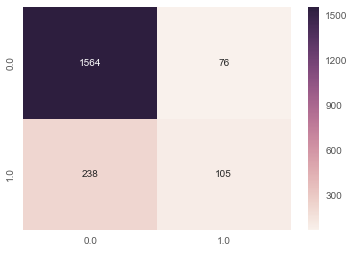

In [74]:
model1.fit(X_train, y_train.ravel())
y_pred = model1.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
labelname = model1.classes_
sns.heatmap(cm, annot=True,  fmt='', xticklabels=labelname, yticklabels=labelname)

Classification Report

In [75]:
report = classification_report(y_test.ravel(), y_pred)
print report

             precision    recall  f1-score   support

        0.0       0.87      0.95      0.91      1640
        1.0       0.58      0.31      0.40       343

avg / total       0.82      0.84      0.82      1983



ROC

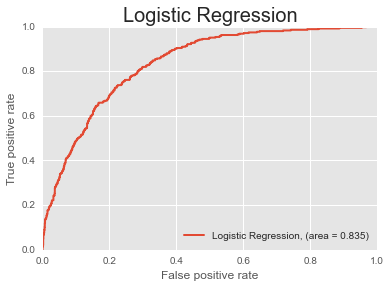

In [76]:
y_pred_proba = model1.predict_proba(X_test)
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_pred_proba[:,1])
roc_rates = [fpr, tpr]
auc = sklearn.metrics.auc(fpr, tpr)
plt.title("Logistic Regression", fontsize = 20)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
labelname = "Logistic Regression" + ", (area = %0.3f)" % auc
plt.plot(roc_rates[0], roc_rates[1], linewidth = 2, label = labelname)
plt.legend(loc = 4)

Log Loss: Training (Cross Validation)

In [77]:
n_samples = X_train.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=20, test_size=0.2, random_state=1)
logloss = cross_validation.cross_val_score(model1, X_train, y_train.ravel(), cv=cv, scoring='log_loss')
print -logloss.mean()

0.398736067734


Log Loss: Testing

In [78]:
sklearn.metrics.log_loss(y_test.ravel(), y_pred_proba[:,1])

0.35639948447380237

#####Quick and Dirty Check: Logistic Regression with RFECV

Accuracy Score: Testing

In [79]:
rfecv = sklearn.feature_selection.RFECV(estimator=model1, step=1, cv=cv, scoring='recall') 
rfecv.fit(X_train, y_train.ravel())
rfecv.score(X_test, y_test.ravel())

0.84266263237518912

Confusion Matrix

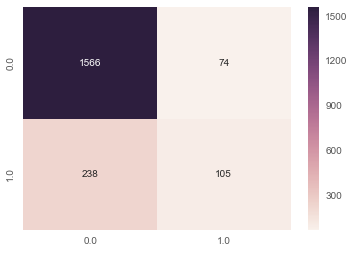

In [80]:
y_pred = rfecv.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
labelname = model1.classes_
sns.heatmap(cm, annot=True,  fmt='', xticklabels=labelname, yticklabels=labelname)

Classification Report

In [81]:
report = classification_report(y_test.ravel(), y_pred)
print report

             precision    recall  f1-score   support

        0.0       0.87      0.95      0.91      1640
        1.0       0.59      0.31      0.40       343

avg / total       0.82      0.84      0.82      1983



ROC

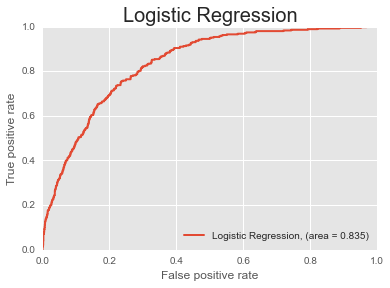

In [82]:
y_pred_proba = rfecv.predict_proba(X_test)
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_pred_proba[:,1])
roc_rates = [fpr, tpr]
auc = sklearn.metrics.auc(fpr, tpr)
plt.title("Logistic Regression", fontsize = 20)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
labelname = "Logistic Regression" + ", (area = %0.3f)" % auc
plt.plot(roc_rates[0], roc_rates[1], linewidth = 2, label = labelname)
plt.legend(loc = 4)

Log Loss: Training(Cross Validation)

In [83]:
n_samples = X_train[:, rfecv.support_].shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=20, test_size=0.2, random_state=1)
model = LogisticRegression()
logloss = cross_validation.cross_val_score(model, X_train[:, rfecv.support_], y_train.ravel(), cv=cv, scoring='log_loss')
print -logloss.mean()

0.398078014452


Log Loss: Testing

In [84]:
sklearn.metrics.log_loss(y_test.ravel(), y_pred_proba[:,1])

0.35644886539562765

####Other Models

GaussianNB

In [85]:
n_samples = X_train.shape[0]
model2 = GaussianNB()
cv = cross_validation.ShuffleSplit(n_samples, n_iter=10, test_size=0.3, random_state=1)
scores = cross_validation.cross_val_score(model2, X_train, y_train.ravel(), cv=cv)
print scores.mean()

0.74987394958


In [86]:
model2.fit(X_train, y_train.ravel())
y_pred = model2.predict(X_test)

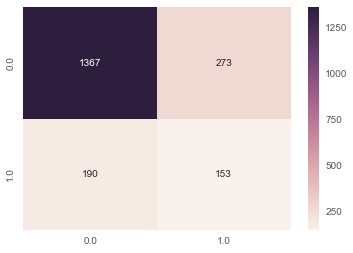

In [87]:
cm = confusion_matrix(y_test, y_pred)
labelname = model2.classes_
sns.heatmap(cm, annot=True,  fmt='', xticklabels=labelname, yticklabels=labelname)

In [88]:
report = classification_report(y_test.ravel(), y_pred)
print report

             precision    recall  f1-score   support

        0.0       0.88      0.83      0.86      1640
        1.0       0.36      0.45      0.40       343

avg / total       0.79      0.77      0.78      1983



SVC

In [89]:
n_samples = X_train.shape[0]
model3 = SVC()
cv = cross_validation.ShuffleSplit(n_samples, n_iter=10, test_size=0.3, random_state=1)
scores = cross_validation.cross_val_score(model3, X_train, y_train.ravel(), cv=cv)
print scores.mean()

0.811596638655


In [90]:
model3.fit(X_train, y_train.ravel())
y_pred = model3.predict(X_test)

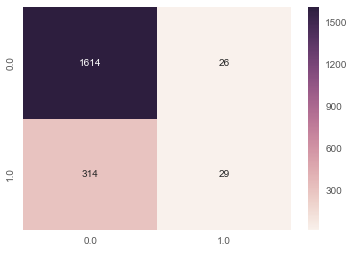

In [91]:
cm = confusion_matrix(y_test, y_pred)
labelname = model3.classes_
sns.heatmap(cm, annot=True,  fmt='', xticklabels=labelname, yticklabels=labelname)

In [92]:
report = classification_report(y_test.ravel(), y_pred)
print report

             precision    recall  f1-score   support

        0.0       0.84      0.98      0.90      1640
        1.0       0.53      0.08      0.15       343

avg / total       0.78      0.83      0.77      1983



Decision Tree

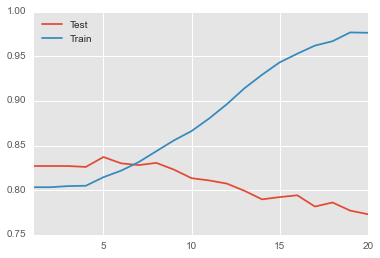

In [93]:
scoresTrain = []
scoresTest=[]
for i in range(1, 21):
    model = DecisionTreeClassifier(max_depth = i)
    model.fit(X_train, y_train.ravel())
    y_train_pred = model.predict(X_train)
    scoresTrain.append(accuracy_score(y_train, y_train_pred))
    y_test_pred = model.predict(X_test)
    scoresTest.append(accuracy_score(y_test, y_test_pred))
plotdata = pd.DataFrame(data={'Train': scoresTrain, 'Test': scoresTest})
plotdata.index=range(1, 21)
%matplotlib inline
matplotlib.style.use('ggplot')
plotdata.plot()

In [94]:
plotdata

,Test,Train
1,0.827030,0.803303
2,0.827030,0.803303
3,0.827030,0.804564
4,0.826021,0.804943
5,0.837115,0.814525
6,0.830055,0.821838
7,0.828038,0.831421
8,0.830560,0.843651
9,0.822995,0.855756
10,0.813414,0.866221


In [95]:
n_samples = X_train.shape[0]
model4 = DecisionTreeClassifier(max_depth = 6)
cv = cross_validation.ShuffleSplit(n_samples, n_iter=10, test_size=0.3, random_state=1)
scores = cross_validation.cross_val_score(model4, X_train, y_train.ravel(), cv=cv)
print scores.mean()

0.799285714286


In [96]:
model4.fit(X_train, y_train.ravel())
y_pred = model4.predict(X_test)

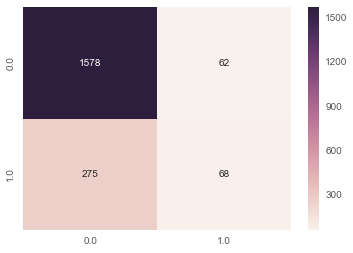

In [97]:
cm = confusion_matrix(y_test, y_pred)
labelname = model3.classes_
sns.heatmap(cm, annot=True,  fmt='', xticklabels=labelname, yticklabels=labelname)

In [98]:
report = classification_report(y_test.ravel(), y_pred)
print report

             precision    recall  f1-score   support

        0.0       0.85      0.96      0.90      1640
        1.0       0.52      0.20      0.29       343

avg / total       0.79      0.83      0.80      1983



Random Forest

In [99]:
n_samples = X_train.shape[0]
model5 = RandomForestClassifier()
cv = cross_validation.ShuffleSplit(n_samples, n_iter=10, test_size=0.3, random_state=1)
scores = cross_validation.cross_val_score(model5, X_train, y_train.ravel(), cv=cv)
print scores.mean()

0.805420168067


In [100]:
model5.fit(X_train, y_train.ravel())
y_pred = model5.predict(X_test)

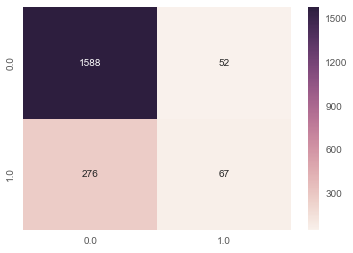

In [101]:
cm = confusion_matrix(y_test, y_pred)
labelname = model5.classes_
sns.heatmap(cm, annot=True,  fmt='', xticklabels=labelname, yticklabels=labelname)

In [102]:
report = classification_report(y_test.ravel(), y_pred)
print report

             precision    recall  f1-score   support

        0.0       0.85      0.97      0.91      1640
        1.0       0.56      0.20      0.29       343

avg / total       0.80      0.83      0.80      1983



K-Nearest Neighbors

In [103]:
scoresTrain = []
scoresTest=[]
for i in range(1, 21):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(X_train, y_train.ravel())
    y_train_pred = model.predict(X_train)
    scoresTrain.append(accuracy_score(y_train, y_train_pred))
    y_test_pred = model.predict(X_test)
    scoresTest.append(accuracy_score(y_test, y_test_pred))

In [104]:
plotdata = pd.DataFrame(data={'Train': scoresTrain, 'Test': scoresTest})
plotdata.index=range(1, plotdata.shape[0] + 1)
plotdata

,Test,Train
1,0.749874,1.000000
2,0.808371,0.867608
3,0.788200,0.870130
4,0.809380,0.842769
5,0.790217,0.846930
6,0.811901,0.833438
7,0.810388,0.834825
8,0.821483,0.831799
9,0.816440,0.832430
10,0.824004,0.826504


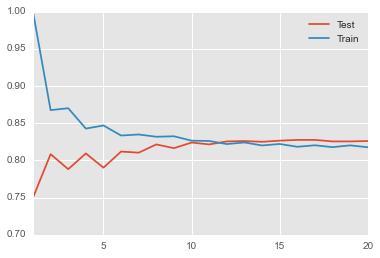

In [105]:
%matplotlib inline
matplotlib.style.use('ggplot')
plotdata.plot()

In [106]:
n_samples = X_train.shape[0]
model6 = KNeighborsClassifier(n_neighbors=18)
cv = cross_validation.ShuffleSplit(n_samples, n_iter=10, test_size=0.3, random_state=1)
scores = cross_validation.cross_val_score(model5, X_train, y_train.ravel(), cv=cv)
print scores.mean()

0.805504201681


In [107]:
model6.fit(X_train, y_train.ravel())
y_pred = model6.predict(X_test)

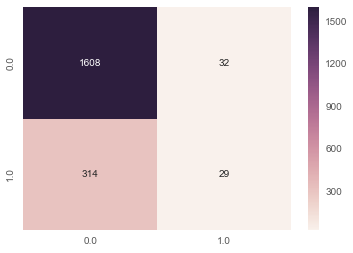

In [108]:
cm = confusion_matrix(y_test, y_pred)
labelname = model6.classes_
sns.heatmap(cm, annot=True,  fmt='', xticklabels=labelname, yticklabels=labelname)

In [109]:
report = classification_report(y_test.ravel(), y_pred)
print report

             precision    recall  f1-score   support

        0.0       0.84      0.98      0.90      1640
        1.0       0.48      0.08      0.14       343

avg / total       0.77      0.83      0.77      1983



#####Plotting ROC Curves

In [110]:
from sklearn import metrics
from sklearn.feature_selection import RFECV

In [111]:
estimators = [
    LogisticRegression(), 
    SVC(probability=True), 
    GaussianNB(), 
    DecisionTreeClassifier(max_depth = 5), 
    RandomForestClassifier(), 
    KNeighborsClassifier(n_neighbors = 10)
    ]

names = ["Logistic Regression", "Support Vector Machine", "Gaussian Naive Bayes", "Decision Tree Classifier",
        "Random Forest Classifier", "K Neighbors - 10"]

colors = ["b", "g", "r", "k", "c", "y"]

In [112]:
def roc_rates(estimator, X_train = X_train, y_train = y_train.ravel(), X_test = X_test, y_test = y_test.ravel()):
    
    #Recursive Features Selection
    model = estimator
    model.fit(X_train, y_train)
    test_pred = model.predict_proba(X_test)
    
    # return the roc parameters
    fpr, tpr, _ = metrics.roc_curve(y_test, test_pred[:,1])
    roc_rates = [fpr, tpr]
    auc = metrics.auc(fpr, tpr)
    return roc_rates, auc

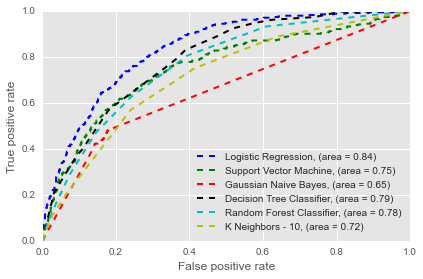

In [115]:
#plt.figure(figsize = (15,12))

for i, model in enumerate(estimators):
    #plt.subplot(2,3, i)
    #plt.title(names[i], fontsize = 20)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    
    # plot parameters using unscaled predictors
    params = roc_rates(estimators[i], X_train, y_train.ravel(), X_test, y_test.ravel())[0]
    area = roc_rates(estimators[i], X_train, y_train.ravel(), X_test, y_test.ravel())[1]
    labelname = names[i] + ", (area = %0.2f)" % area
    plt.plot(params[0], params[1], colors[i] + "--", linewidth = 2, label = labelname)
    plt.legend(loc = 4)

plt.tight_layout()
plt.show()

####Calculating Log Loss

In [ ]:
for i, estimator in enumerate(estimators):
    model = estimator
    model.fit(X_train, y_train.ravel())
    y_pred = model.predict_proba(X_test)
    ll = metrics.log_loss(y_test.ravel(), y_pred[:,1])
    print names[i] + ', LogLoss: %0.2f'% ll

In [ ]:
n_samples = X_train.shape[0]
model = estimators[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=20, test_size=0.2, random_state=1)
logloss = cross_validation.cross_val_score(model, np.array(X), np.array(y).ravel(), cv=cv, scoring='log_loss')
print -logloss.mean()

#####Incorporating Feature Selection

In [ ]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

In [ ]:
n_samples = X_train.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=10, test_size=0.3, random_state=1)

Logistic Regression

In [ ]:
model = LogisticRegression()
rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='recall') 
rfecv.fit(X_train, y_train.ravel())
test_pred = rfecv.predict_proba(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test, test_pred[:,1])
roc_rates = [fpr, tpr]
auc = metrics.auc(fpr, tpr)
plt.title("Logistic Regression", fontsize = 20)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
labelname = "Logistic Regression" + ", (area = %0.2f)" % auc
plt.plot(roc_rates[0], roc_rates[1], colors[i] + "--", linewidth = 2, label = labelname)
plt.legend(loc = 4)

Comparing model with reduced features against original model

In [ ]:
rfecv.score(X_test, y_test.ravel())

In [ ]:
y_pred = rfecv.predict_proba(X_test)
ll = metrics.log_loss(y_test.ravel(), y_pred[:,1])
print names[0] + ', LogLoss: %0.2f'% ll

In [ ]:
y_pred = rfecv.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
labelname = model1.classes_
sns.heatmap(cm, annot=True,  fmt='', xticklabels=labelname, yticklabels=labelname)

In [ ]:
report = classification_report(y_test.ravel(), y_pred)
print report

In [ ]:
model1 = LogisticRegression()
model1.fit(X_train, y_train.ravel())
model1.score(X_test, y_test.ravel())

Random Forest Classifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

In [ ]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X_train, y_train.ravel())
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

#Print the feature ranking
print("Feature ranking:")

for f in range(len(features)):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]])), features[float(indices[f])]